# SPTAN1
The spectrins, including nonerythrocytic alpha-spectrin-1 (SPTAN1), are a family of widely-distributed filamentous cytoskeletal proteins which have a highly conserved 106-amino acid repeat structure [OMIM:182810](https://omim.org/entry/182810).

Variants in SPTAN1 are associated with four diseases:

- Developmental and epileptic encephalopathy 5: [OMIM:613477](https://omim.org/entry/613477)
- Developmental delay with or without epilepsy: [OMIM:620540](https://omim.org/entry/620540)
- Neuronopathy, distal hereditary motor, autosomal dominant 11: [OMIM:620528](https://omim.org/entry/620528)
- Spastic paraplegia 91, autosomal dominant, with or without cerebellar ataxia: [OMIM:620538](https://omim.org/entry/620538)


[Van de Vondel  et al (2022)](https://pubmed.ncbi.nlm.nih.gov/35150594/) state:

> Although age of onset, disease severity and some phenotypical traits can differ, correlations can be made between SPTAN1 variants and the predominantly associated phenotype, such as the p.Lys2083del mutation in the cerebellar atactic phenotype and the p.ç mutation in the HSP phenotype. C-terminal in-frame insertions, deletions and duplications are highly linked to severe, early-onset epileptic encephalopathies and West syndrome. These variants are located within the spectrin dimerization domain, and one has been shown to cause spectrin aggregates in patient-derived iPSCs. In contrast, nonsense mutations are seen more frequently in patients with mild HMN, where a haploinsuffiency mechanism is proposed due to nonsense-mediated decay.

[Morsey et al. (2022)](https://pubmed.ncbi.nlm.nih.gov/36331550/) suggest that

>  truncating variants are responsible for a mild DD with or without epilepsy.

In [1]:
import gpsea
import hpotk
import numpy as np

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using genophenocorr version 0.7.1


# SPTAN1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SPTAN1.

In [2]:
gene_symbol = 'SPTAN1'
mane_tx_id = 'NM_001130438.3'
mane_protein_id = "NP_001123910.1" # spectrin alpha chain, non-erythrocytic 1 isoform

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 85/85 [00:05<00:00, 16.63individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Intellectual disability,HP:0001249,27
Spastic paraplegia,HP:0001258,21
Ataxia,HP:0001251,20
Distal lower limb muscle weakness,HP:0009053,20
Global developmental delay,HP:0001263,20
Abnormal pyramidal sign,HP:0007256,19
Microcephaly,HP:0000252,19
Hypotonia,HP:0001252,16
Hypsarrhythmia,HP:0002521,16
Cerebellar atrophy,HP:0001272,16


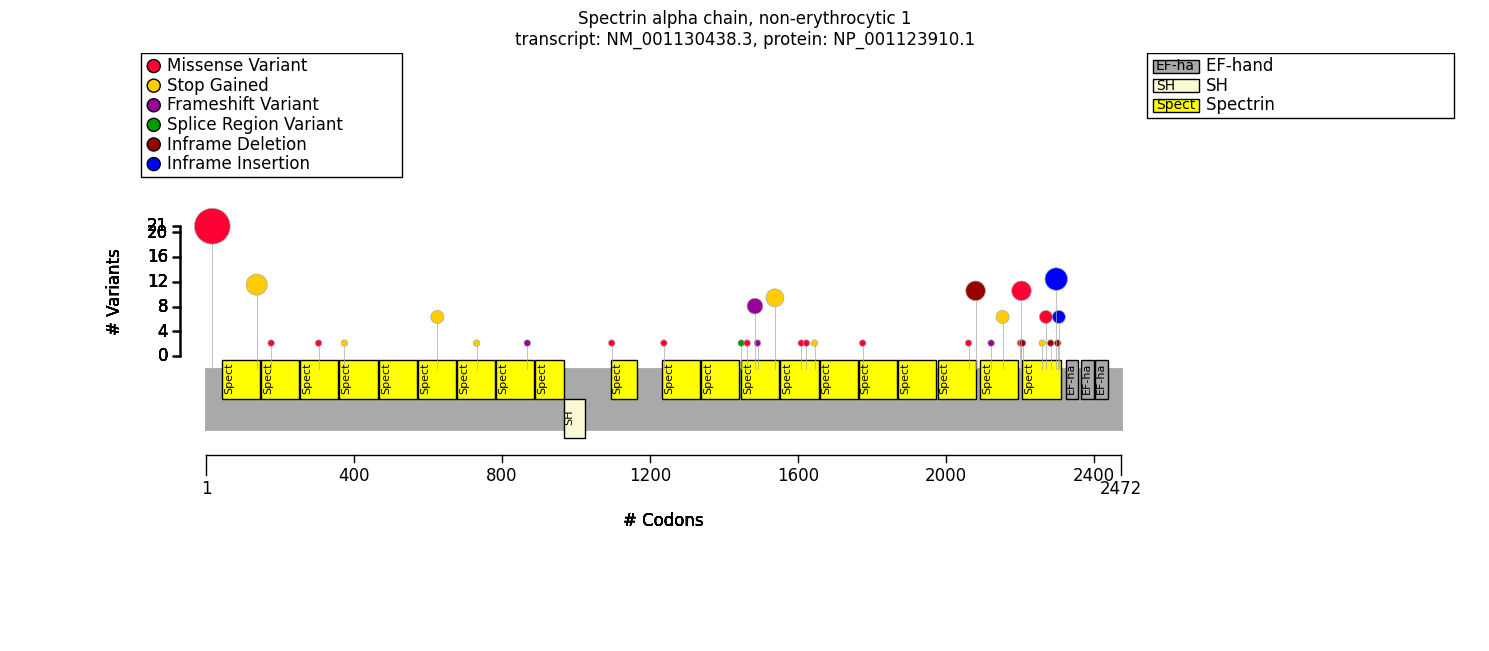

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


sptan1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
sptan1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
viewer.process(cohort)

Name,Type,Coordinates,Count,Variants
Spectrin 1,REPEAT,45 - 146,6,p.Arg139Ter
Spectrin 2,REPEAT,150 - 251,1,p.Gly178Asp
Spectrin 3,REPEAT,256 - 358,1,p.Ala306Val
Spectrin 4,REPEAT,361 - 465,1,p.Trp376Ter
Spectrin 5,REPEAT,468 - 570,0,
Spectrin 6,REPEAT,574 - 676,2,p.Arg627Ter
Spectrin 7,REPEAT,679 - 781,1,p.Arg733Ter
Spectrin 8,REPEAT,785 - 888,1,p.Lys871SerfsTer5
Spectrin 9,REPEAT,891 - 969,0,
SH3,DOMAIN,967 - 1026,0,


In [7]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
9_128566795_128566795_C_T,c.55C>T,p.Arg19Trp,2,missense,21
9_128632260_128632260_G_GGGACCAGCT,c.6908_6916dup,p.Asp2303_Leu2305dup,53,inframe insertion,6
9_128574726_128574726_C_T,c.415C>T,p.Arg139Ter,4,stop gained,6
9_128625939_128625942_CAAG_C,c.6247_6249del,p.Lys2083del,48,inframe deletion,5
SO:1000029_HGNC:11273_SPTAN1,SV involving SPTAN1,p.?,,chromosomal deletion,4
9_128627422_128627425_CAGG_C,c.6619_6621del,p.Glu2207del,50,inframe deletion,4
9_128609141_128609141_C_T,c.4615C>T,p.Gln1539Ter,36,stop gained,4
9_128608237_128608238_CA_C,c.4458del,p.Lys1486AsnfsTer51,34,frameshift,3
9_128632175_128632175_G_A,c.6811G>A,p.Glu2271Lys,53,missense,2
9_128632280_128632280_G_GGCATGC,c.6923_6928dup,p.Arg2308_Met2309dup,53,inframe insertion,2


## Genotype-Phenotype Correlation (GPC) Analysis

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate
from gpsea.view import MtcStatsViewer

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_predicate = monoallelic_predicate(a_predicate=missense, 
                                    b_predicate=~missense, 
                                    a_label="missense",
                                    b_label= "other"
                                   )

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,23
HMF08,Skipping general term,43
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,187


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                   missense          other  \
                                                  Count Percent  Count   
Lower limb spasticity [HP:0002061]                21/22     95%   0/12   
Spastic paraplegia [HP:0001258]                   21/25     84%   0/16   
Appendicular spasticity [HP:0034353]              21/22     95%   2/14   
Spasticity [HP:0001257]                           22/23     96%   4/16   
Epileptic spasm [HP:0011097]                       2/22      9%  13/17   
Seizure [HP:0001250]                              13/33     39%  24/28   
Intellectual disability [HP:0001249]               9/32     28%  18/23   
Peripheral axonal neuropathy [HP:0003477]          4/23     17%  12/16   
Motor seizure [HP:0020219]                         7/27     26%  13/17   
Infantile spasms [HP:0012469]                      2/29      7%  13/31   
Microcephaly [HP:0000252]                          4/34     12%  15/32   
Lower limb muscle weakness [HP:0007340]           15/16     94%  15/27   
Hypotonia [HP:0001252]                              3/9     33%  13/26   
Ataxia [HP:0001251]                               11/30     37%   9/20   
Distal lower limb muscle weakness [HP:0009053]     9/19     47%  11/27   
Abnormal muscle tone [HP:0003808]                 24/24    100%  16/16   
Neurodevelopmental delay [HP:0012758]               5/5    100%  30/30   
Neurodevelopmental abnormality [HP:0012759]       11/11    100%  35/35   
Muscle weakness [HP:0001324]                      17/17    100%  19/19   

Allele group                                                               \
                                               Percent Corrected p values   
Lower limb spasticity [HP:0002061]                  0%       4.465332e-07   
Spastic paraplegia [HP:0001258]                     0%       4.465332e-07   
Appendicular spasticity [HP:0034353]               14%       5.525384e-06   
Spasticity [HP:0001257]                            25%       2.480725e-05   
Epileptic spasm [HP:0011097]                       76%       1.111576e-04   
Seizure [HP:0001250]                               86%       7.856689e-04   
Intellectual disability [HP:0001249]               78%       9.304824e-04   
Peripheral axonal neuropathy [HP:0003477]          75%       1.588871e-03   
Motor seizure [HP:0020219]                         76%       3.598898e-03   
Infantile spasms [HP:0012469]                      42%       4.225493e-03   
Microcephaly [HP:0000252]                          47%       4.225493e-03   
Lower limb muscle weakness [HP:0007340]            56%       2.268190e-02   
Hypotonia [HP:0001252]                             50%       6.730260e-01   
Ataxia [HP:0001251]                                45%       7.760544e-01   
Distal lower limb muscle weakness [HP:0009053]     41%       9.699097e-01   
Abnormal muscle tone [HP:0003808]                 100%       1.000000e+00   
Neurodevelopmental delay [HP:0012758]             100%       1.000000e+00   
Neurodevelopmental abnormality [HP:0012759]       100%       1.000000e+00   
Muscle weakness [HP:0001324]                      100%       1.000000e+00   

Allele group                                                  
                                                    p values  
Lower limb spasticity [HP:0002061]              2.370731e-08  
Spastic paraplegia [HP:0001258]                 4.700349e-08  
Appendicular spasticity [HP:0034353]            8.724291e-07  
Spasticity [HP:0001257]                         5.222578e-06  
Epileptic spasm [HP:0011097]                    2.925201e-05  
Seizure [HP:0001250]                            2.481060e-04  
Intellectual disability [HP:0001249]            3.428093e-04  
Peripheral axonal neuropathy [HP:0003477]       6.689983e-04  
Motor seizure [HP:0020219]                      1.704741e-03  
Infantile spasms [HP:0012469]                   2.364326e-03  
Microcephaly [HP:0000252]                       2.446338e-03  
Lower li

In [22]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

nonsense = VariantPredicates.variant_effect(VariantEffect.STOP_GAINED, tx_id=mane_tx_id)
frameshift = VariantPredicates.variant_effect(VariantEffect.FRAMESHIFT_VARIANT, tx_id=mane_tx_id)
truncating = VariantPredicates.any((nonsense, frameshift))

truncating_predicate = monoallelic_predicate(a_predicate=truncating, 
                                    b_predicate=~truncating, 
                                    a_label="truncating",
                                    b_label= "other"
                                   )

truncating_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=truncating_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=truncating_result)

Allele group        truncating          other                             \
                         Count Percent  Count Percent Corrected p values   
Ataxia [HP:0001251]       2/10     20%  18/40     45%           0.278927   

Allele group                   
                     p values  
Ataxia [HP:0001251]  0.278927

In [11]:
r19w = VariantPredicates.variant_key(key="9_128566795_128566795_C_T") # c.55C>T	p.Arg19Trp
r19w_predicate = monoallelic_predicate(
    a_predicate=r19w,
    b_predicate=~r19w,
    a_label="Arg19Trp",
    b_label="Other"
)

r19w_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=r19w_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=r19w_result)

Allele group                                   Arg19Trp          Other  \
                                                  Count Percent  Count   
Spastic paraplegia [HP:0001258]                   21/21    100%   0/20   
Lower limb spasticity [HP:0002061]                21/21    100%   0/13   
Intellectual disability [HP:0001249]               0/21      0%  27/34   
Seizure [HP:0001250]                               2/21     10%  35/40   
Motor seizure [HP:0020219]                         0/19      0%  20/25   
Appendicular spasticity [HP:0034353]              21/21    100%   2/15   
Epileptic spasm [HP:0011097]                       0/19      0%  15/20   
Spasticity [HP:0001257]                           21/21    100%   5/18   
Microcephaly [HP:0000252]                          0/21      0%  19/45   
Lower limb muscle weakness [HP:0007340]           14/14    100%  16/29   
Peripheral axonal neuropathy [HP:0003477]          4/20     20%  12/19   
Distal lower limb muscle weakness [HP:0009053]     8/15     53%  12/31   
Ataxia [HP:0001251]                                7/21     33%  13/29   
Abnormal muscle tone [HP:0003808]                 21/21    100%  19/19   
Muscle weakness [HP:0001324]                      16/16    100%  20/20   

Allele group                                                               \
                                               Percent Corrected p values   
Spastic paraplegia [HP:0001258]                     0%       5.573537e-11   
Lower limb spasticity [HP:0002061]                  0%       8.082038e-09   
Intellectual disability [HP:0001249]               79%       8.791727e-09   
Seizure [HP:0001250]                               88%       8.839762e-09   
Motor seizure [HP:0020219]                         80%       1.002618e-07   
Appendicular spasticity [HP:0034353]               13%       1.135975e-07   
Epileptic spasm [HP:0011097]                       75%       1.651837e-06   
Spasticity [HP:0001257]                            28%       1.977857e-06   
Microcephaly [HP:0000252]                          42%       4.090175e-04   
Lower limb muscle weakness [HP:0007340]            55%       4.889220e-03   
Peripheral axonal neuropathy [HP:0003477]          63%       1.299560e-02   
Distal lower limb muscle weakness [HP:0009053]     39%       6.463342e-01   
Ataxia [HP:0001251]                                45%       6.463342e-01   
Abnormal muscle tone [HP:0003808]                 100%       1.000000e+00   
Muscle weakness [HP:0001324]                      100%       1.000000e+00   

Allele group                                                  
                                                    p values  
Spastic paraplegia [HP:0001258]                 3.715691e-12  
Lower limb spasticity [HP:0002061]              1.077605e-09  
Intellectual disability [HP:0001249]            1.758345e-09  
Seizure [HP:0001250]                            2.357270e-09  
Motor seizure [HP:0020219]                      3.342060e-08  
Appendicular spasticity [HP:0034353]            4.543901e-08  
Epileptic spasm [HP:0011097]                    7.708573e-07  
Spasticity [HP:0001257]                         1.054857e-06  
Microcephaly [HP:0000252]                       2.454105e-04  
Lower limb muscle weakness [HP:0007340]         3.259480e-03  
Peripheral axonal neuropathy [HP:0003477]       9.530109e-03  
Distal lower limb muscle weakness [HP:0009053]  5.266821e-01  
Ataxia [HP:0001251]                             5.601563e-01  
Abnormal muscle tone [HP:0003808]               1.000000e+00  
Muscle weakness [HP:0001324]                    1.000000e+00

According to [Van de Vondel  et al (2022)](https://pubmed.ncbi.nlm.nih.gov/35150594/), the p.Lys2083del mutation is associated with a cerebellar atactic phenotype. We show here that if one tests against all terms, there is a nominally significant result that does not survive multiple testing correction. We also show how to test specifically for the term Ataxia.

In [ ]:
k2083del = VariantPredicates.variant_key(key="9_128625939_128625942_CAAG_C") # c.6247_6249del	p.Lys2083del	
k2083del_predicate = monoallelic_predicate(
    a_predicate=k2083del,
    b_predicate=~k2083del,
    a_label="Lys2083del",
    b_label="Other"
)

k2083del_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=k2083del_predicate,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=k2083del_result)

Allele group                                   Lys2083del          Other  \
                                                    Count Percent  Count   
Ataxia [HP:0001251]                                   5/5    100%  15/45   
Spastic paraplegia [HP:0001258]                       0/4      0%  21/37   
Seizure [HP:0001250]                                  1/5     20%  36/56   
Motor seizure [HP:0020219]                            0/4      0%  20/40   
Distal lower limb muscle weakness [HP:0009053]        0/4      0%  20/42   
Peripheral axonal neuropathy [HP:0003477]             0/4      0%  16/35   
Epileptic spasm [HP:0011097]                          0/4      0%  15/35   
Intellectual disability [HP:0001249]                  4/5     80%  23/50   
Neurodevelopmental delay [HP:0012758]                 1/1    100%  34/34   
Neurodevelopmental abnormality [HP:0012759]           4/4    100%  42/42   

Allele group                                                               \
                                               Percent Corrected p values   
Ataxia [HP:0001251]                                33%           0.073175   
Spastic paraplegia [HP:0001258]                    57%           0.208265   
Seizure [HP:0001250]                               64%           0.208265   
Motor seizure [HP:0020219]                         50%           0.208265   
Distal lower limb muscle weakness [HP:0009053]     48%           0.208265   
Peripheral axonal neuropathy [HP:0003477]          46%           0.208265   
Epileptic spasm [HP:0011097]                       43%           0.208265   
Intellectual disability [HP:0001249]               46%           0.240894   
Neurodevelopmental delay [HP:0012758]             100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]       100%           1.000000   

Allele group                                              
                                                p values  
Ataxia [HP:0001251]                             0.007317  
Spastic paraplegia [HP:0001258]                 0.047842  
Seizure [HP:0001250]                            0.073232  
Motor seizure [HP:0020219]                      0.113966  
Distal lower limb muscle weakness [HP:0009053]  0.121304  
Peripheral axonal neuropathy [HP:0003477]       0.129786  
Epileptic spasm [HP:0011097]                    0.145785  
Intellectual disability [HP:0001249]            0.192715  
Neurodevelopmental delay [HP:0012758]           1.000000  
Neurodevelopmental abnormality [HP:0012759]     1.000000

In [ ]:
from gpsea.analysis.mtc_filter import SpecifiedTermsMtcFilter
specified_terms = SpecifiedTermsMtcFilter(
    terms_to_test=(
        "HP:0001251",  # Ataxia
    )
)

from gpsea.analysis.pcats import HpoTermAnalysis
from gpsea.analysis.pcats.stats import FisherExactTest
analysis = HpoTermAnalysis(
    count_statistic=FisherExactTest(),
    mtc_filter=specified_terms,
    mtc_correction='bonferroni',  #    
)
k2083del_specific_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=k2083del_predicate,
    pheno_predicates=specified_terms,
)
summarize_hpo_analysis(hpo=hpo, result=k2083del_specific_result)


TypeError: SpecifiedTermsMtcFilter.filter() missing 4 required positional arguments: 'gt_predicate', 'ph_predicates', 'counts', and 'cohort_size'

In [12]:
from gpsea.analysis.predicate.genotype import sex_predicate
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                            FEMALE           MALE          \
                                                Count Percent  Count Percent   
Intellectual disability [HP:0001249]             7/24     29%  20/31     65%   
Spastic paraplegia [HP:0001258]                 13/19     68%   8/22     36%   
Hypotonia [HP:0001252]                           9/14     64%   7/21     33%   
Lower limb muscle weakness [HP:0007340]         19/23     83%  11/20     55%   
Distal lower limb muscle weakness [HP:0009053]  12/21     57%   8/25     32%   
Lower limb spasticity [HP:0002061]              13/17     76%   8/17     47%   
Appendicular spasticity [HP:0034353]            14/18     78%   9/18     50%   
Spasticity [HP:0001257]                         15/19     79%  11/20     55%   
Ataxia [HP:0001251]                             10/21     48%  10/29     34%   
Seizure [HP:0001250]                            16/29     55%  21/32     66%   
Epileptic spasm [HP:0011097]                     9/22     41%   6/17     35%   
Abnormal muscle tone [HP:0003808]               24/24    100%  16/16    100%   
Neurodevelopmental delay [HP:0012758]           16/16    100%  19/19    100%   
Neurodevelopmental abnormality [HP:0012759]     18/18    100%  28/28    100%   
Peripheral axonal neuropathy [HP:0003477]        8/20     40%   8/19     42%   
Motor seizure [HP:0020219]                      10/23     43%  10/21     48%   
Muscle weakness [HP:0001324]                    22/22    100%  14/14    100%   

Sex                                                                          
                                               Corrected p values  p values  
Intellectual disability [HP:0001249]                     0.242930  0.014290  
Spastic paraplegia [HP:0001258]                          0.373991  0.061604  
Hypotonia [HP:0001252]                                   0.373991  0.093724  
Lower limb muscle weakness [HP:0007340]                  0.373991  0.094302  
Distal lower limb muscle weakness [HP:0009053]           0.373991  0.135807  
Lower limb spasticity [HP:0002061]                       0.373991  0.157057  
Appendicular spasticity [HP:0034353]                     0.373991  0.164182  
Spasticity [HP:0001257]                                  0.373991  0.175996  
Ataxia [HP:0001251]                                      0.741802  0.392718  
Seizure [HP:0001250]                                     0.751042  0.441789  
Epileptic spasm [HP:0011097]                             1.000000  0.752638  
Abnormal muscle tone [HP:0003808]                        1.000000  1.000000  
Neurodevelopmental delay [HP:0012758]                    1.000000  1.000000  
Neurodevelopmental abnormality [HP:0012759]              1.000000  1.000000  
Peripheral axonal neuropathy [HP:0003477]                1.000000  1.000000  
Motor seizure [HP:0020219]                               1.000000  1.000000  
Muscle weakness [HP:0001324]                             1.000000  1.000000

# Summary

In [14]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=r19w_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "Intellectual disability was more frequent in males than in females. The nominal p-value was 0.014290 but the corrected " 
"p-value was non-significant"

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [15]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

HPO Term,missense,other,p-val,adj. p-val
Spastic paraplegia [HP:0001258],21/25 (84%),0/16 (0%),4.70e-08,4.47e-07
Lower limb spasticity [HP:0002061],21/22 (95%),0/12 (0%),2.37e-08,4.47e-07
Appendicular spasticity [HP:0034353],21/22 (95%),2/14 (14%),8.72e-07,5.53e-06
Spasticity [HP:0001257],22/23 (96%),4/16 (25%),5.22e-06,2.48e-05
Peripheral axonal neuropathy [HP:0003477],4/23 (17%),12/16 (75%),6.69e-04,0.002
Motor seizure [HP:0020219],7/27 (26%),13/17 (76%),0.002,0.004
Seizure [HP:0001250],13/33 (39%),24/28 (86%),2.48e-04,7.86e-04
Intellectual disability [HP:0001249],9/32 (28%),18/23 (78%),3.43e-04,9.30e-04
Lower limb muscle weakness [HP:0007340],15/16 (94%),15/27 (56%),0.014,0.023
Microcephaly [HP:0000252],4/34 (12%),15/32 (47%),0.002,0.004


In [16]:
summarizer.process_latex(report=report, protein_fig=sptan1_fig)

Figure saved to ../../supplement/img/SPTAN1_protein_diagram-draft.pdf
Output to ../../supplement/tex/SPTAN1_summary_draft.tex
